# Tester for probabilistic regression using zuko

Note that the zuko library (https://github.com/probabilists/zuko/) is also suitable for probabilistic regression. 

In [9]:
#%uv pip install zuko
import numpy as np
import matplotlib.pyplot as plt

## DGP

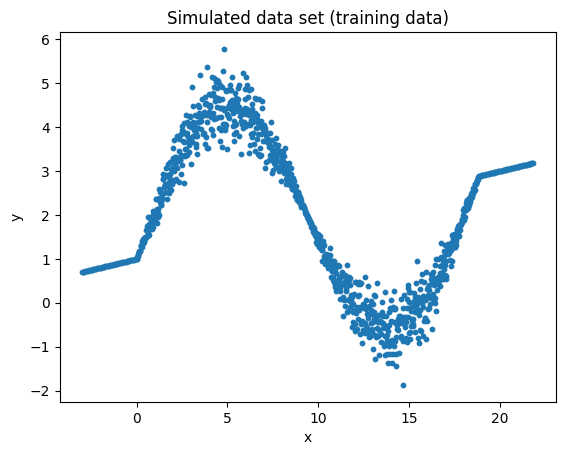

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def dgp_1(n):
    np.random.seed(42)
    N = 1000 # number of data points
    x_train = np.random.uniform(-10, 10, (N, 1)).astype(np.float32)
    y_train = (2 * x_train + np.random.normal(0, np.abs(x_train) + 1, (N, 1))).astype(np.float32)
    return x_train.reshape(1,-1), y_train.reshape(1,-1)


def dgp_2(n):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x.reshape(-1,1),y.reshape(-1,1)

dgp = dgp_2

x_train, y_train = dgp(1000)
plt.scatter(x_train, y_train, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated data set (training data)')

# Predict the distribution
x_test = np.linspace(-10, 30, 100).reshape(-1, 1)

In [11]:
import os
import numpy as np
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import time
print(f"torch version: {torch.__version__}")

# Print Information on GPU
# Check GPU availability
if torch.cuda.is_available():
  print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
  print("GPU is not available.")


torch version: 2.9.1
GPU is not available.


## Probabilistic Regression using NN

Using zuko, we will implement a probabilistic regression model with a probability as output (probabilistic head).

In [16]:
import zuko

class GaussianModel(zuko.lazy.LazyDistribution):
    def __init__(self):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 2),  # mu, log(sigma)
        )

    def forward(self, x: torch.Tensor):
        output = self.net(x)  # Shape: (batch_size, 2)
        mu = output[:, 0:1]  # Shape: (batch_size, 1) - keeps dimension
        raw_sigma = output[:, 1:2]  # Shape: (batch_size, 1) - keeps dimension
        return torch.distributions.Normal(mu, torch.nn.functional.softplus(raw_sigma))

model = GaussianModel()
model

GaussianModel(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [29]:
x = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)
print(x.shape, y.shape)
dist = model(x[0:3])
# Sample 10 samples from the distribution
dist.sample(), dist.log_prob(y[0:3])

torch.Size([1120, 1]) torch.Size([1120, 1])


(tensor([[0.6975],
         [0.6920],
         [0.7031]]),
 tensor([[4.1615],
         [4.1904],
         [4.2149]], grad_fn=<SubBackward0>))

In [28]:
from tqdm import trange
optimizer = torch.optim.Adam(model.parameters())
loss_history = []
batch_size = 128
n_samples = x.shape[0]
n_epochs = 1000

for epoch in trange(n_epochs, desc="Epochs"):
    epoch_losses = []
    # Shuffle indices at the start of each epoch
    idx = torch.randperm(n_samples)
    for i in range(0, n_samples, batch_size):
        batch_idx = idx[i:i+batch_size]
        x_batch = x[batch_idx]
        y_batch = y[batch_idx]
        
        loss = -model(x_batch).log_prob(y_batch).mean()  # E[-log q(y | x)]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_losses.append(loss.detach().numpy())
    
    # Record average loss for this epoch
    loss_history.append(np.mean(epoch_losses))

Epochs: 100%|██████████| 1000/1000 [00:05<00:00, 185.89it/s]


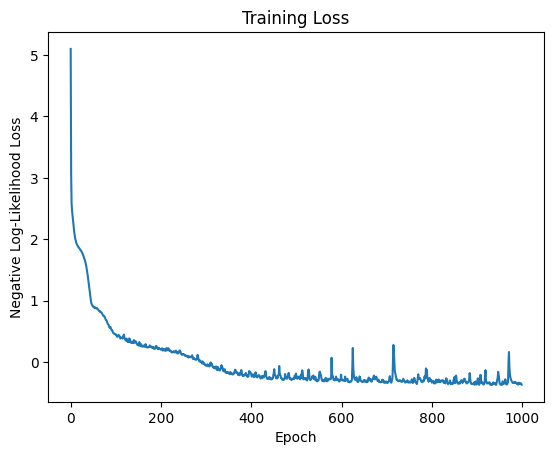

In [30]:
### Plotting the loss curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood Loss")
plt.title("Training Loss")
plt.show()

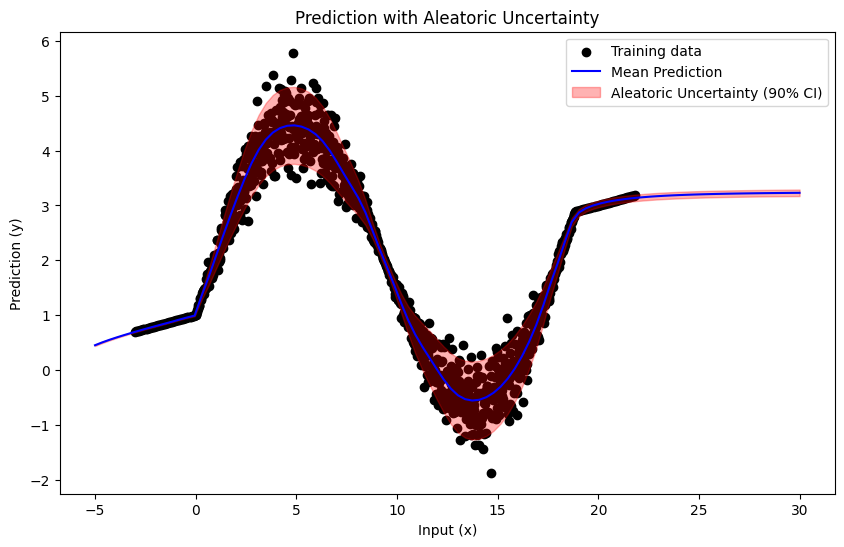

In [31]:
x = torch.linspace(-5, 30, 100).reshape(-1, 1)
# The model predictions are a torch distribution object 
dist = model(x)
# Berechne Quantile direkt aus der Verteilung
# Compute 5% and 95% quantiles directly
quantile_5 = dist.icdf(torch.tensor(0.05)).cpu().detach().numpy()
quantile_95 = dist.icdf(torch.tensor(0.95)).cpu().detach().numpy()
mean = dist.mean.cpu().detach().numpy().squeeze()
# Visualisierung
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color="black", label="Training data")
plt.plot(x, mean, color="blue", label="Mean Prediction")
plt.fill_between(
    x.ravel(),
    quantile_5.squeeze(),  # 5%-Quantil
    quantile_95.squeeze(),  # 95%-Quantil
    color="red",
    alpha=0.3,
    label="Aleatoric Uncertainty (90% CI)"
)
plt.legend()
plt.xlabel("Input (x)")
plt.ylabel("Prediction (y)")
plt.title("Prediction with Aleatoric Uncertainty")
plt.show()